In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Add library's path to notebook
import os
import sys
sys.path.append('../../time-series-featurizer/')
from ts_featurizer import TimeSeriesFeaturizer
%matplotlib inline
raw_files = glob('/media/joanes/0BB3-1FA1/CSV_DATA/*.csv')

In [2]:

def get_df_list_and_target(files):
	# Get only those values that are available before the analysis
	filter_cols = ['Total_UnfilledZones', 'Total_FillingQuality', 'TOTAL_QUALITY', 'Total_PorosityQuantity',
				   'Total_PorosityQuality', 'Time']
	df_list = list()
	target = list()
	for file in files:
		df = pd.read_csv(file)
		target.append(df.TOTAL_QUALITY.unique()[0])
		df_filtered = df.drop(axis=1, columns=filter_cols)
		filter_col = [col for col in df_filtered if
					  not col.endswith(('VoidContent', 'VoidQuality', 'Filling', 'FillingQuality'))]
		df_filtered = df_filtered[filter_col]
		df_list.append(df_filtered)

	target = pd.DataFrame(target, columns=['valid'])
	return df_list, target



In [3]:
def split_df(df, indexes, starting_index=0):
    df_list = []
    for index, i in enumerate(indexes[:len(indexes)]):
        df_slice = df[starting_index:i].reset_index()
        df_slice.rename(columns=lambda x: f'slice_{index}_{x}', inplace=True)
        df_list.append(df_slice)
        starting_index = i
    df_slice = df[indexes[-1]:].reset_index()
    df_slice.rename(columns=lambda x: f'slice_{index + 1}_{x}', inplace=True)
    df_list.append(df_slice)
    return df_list

In [42]:
import peakutils
from scipy.signal import savgol_filter


def get_processed_df_list_and_target(raw_files, start, end):
    df_ret = []
    df_list, targets = get_df_list_and_target(raw_files[start:end])
    for i, data in enumerate(df_list):
        flow_rate_filtered = savgol_filter(data['Flow rate'].values, 51, 2)
        flow_rate_deriv = np.diff(flow_rate_filtered) * -1
        flow_rate = flow_rate_deriv[550:]
        np.place(flow_rate, flow_rate < 0, [0])
        indexes = peakutils.indexes(flow_rate, thres=0.2, min_dist=10) + 550
        df_ret.append(data[indexes[0]:])
#         plt.plot(flow_rate_filtered)
#         plt.plot(data[indexes[0]:]['Flow rate'])
#         plt.show()
    return df_ret, targets

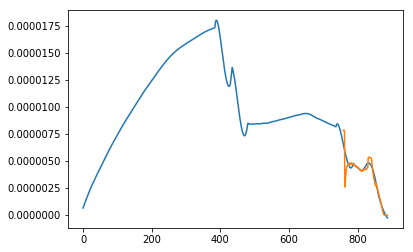

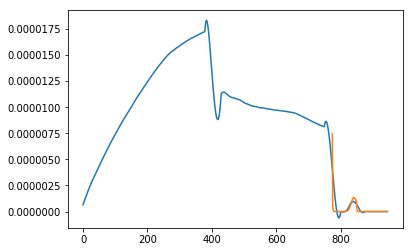

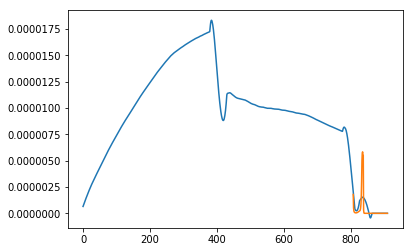

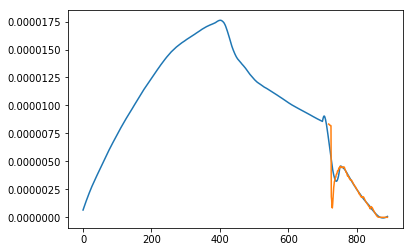

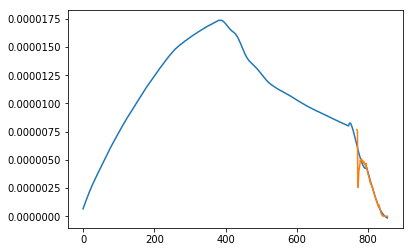

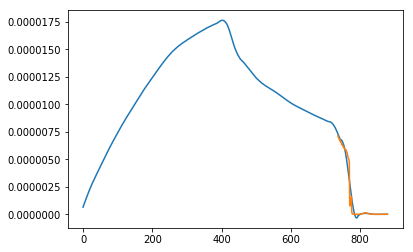

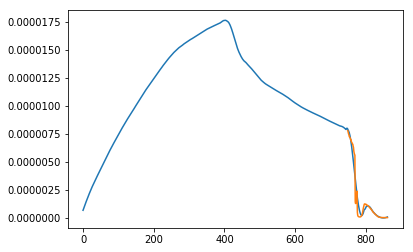

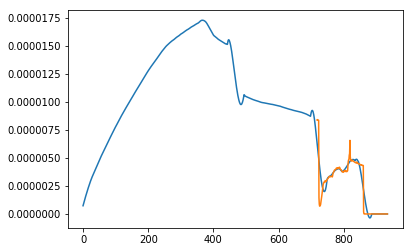

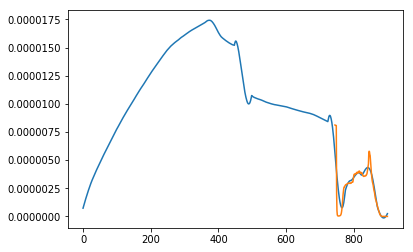

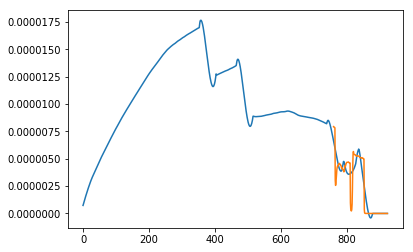

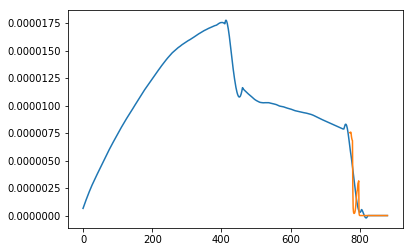

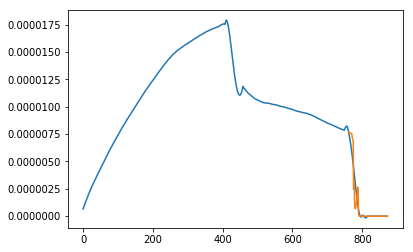

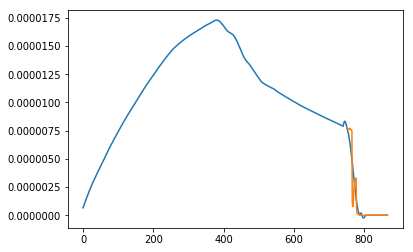

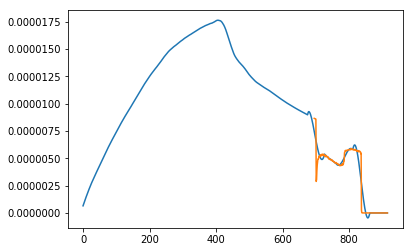

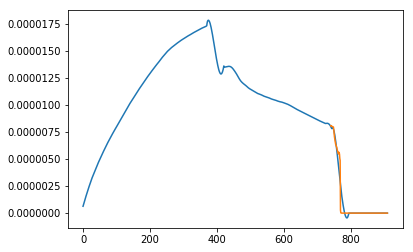

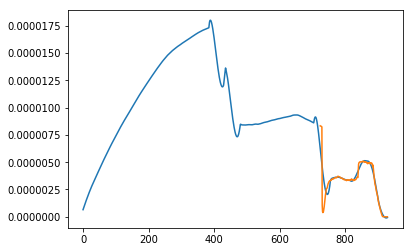

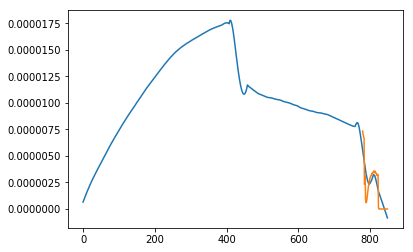

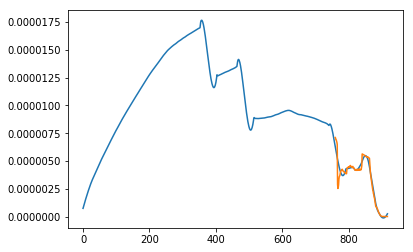

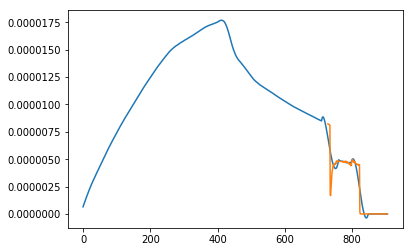

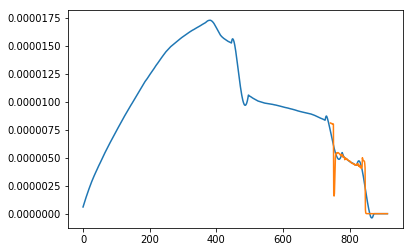

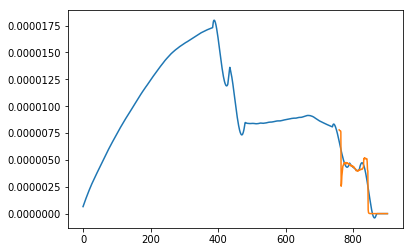

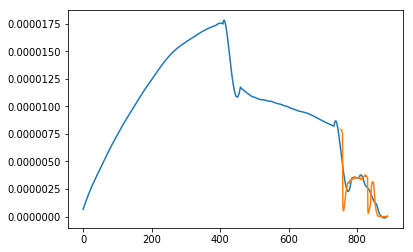

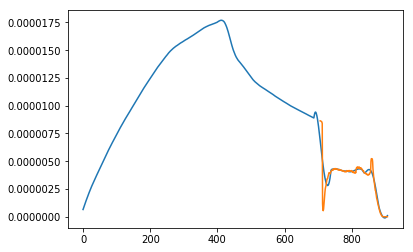

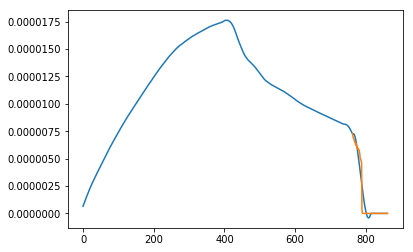

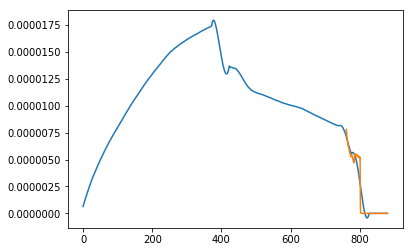

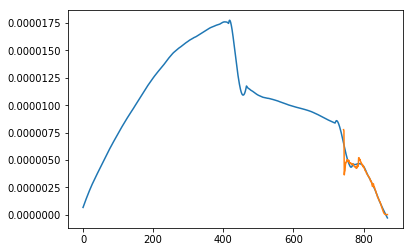

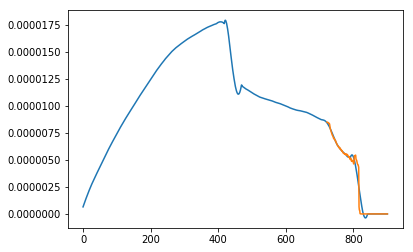

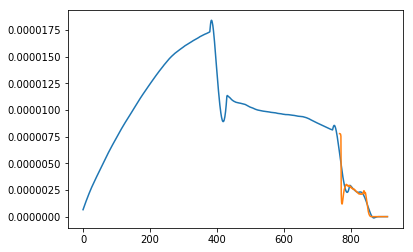

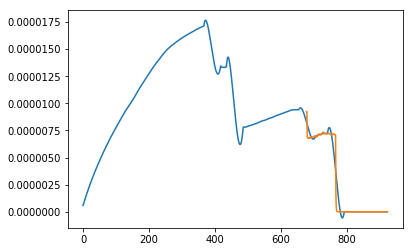

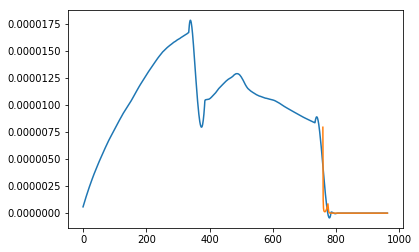

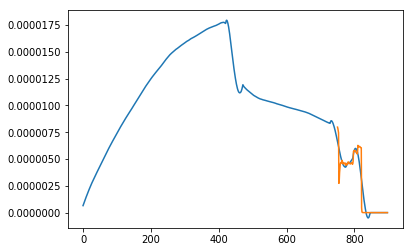

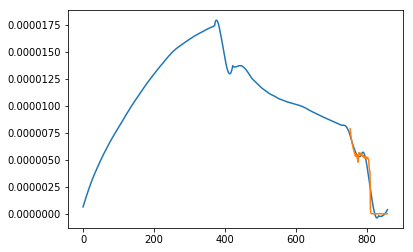

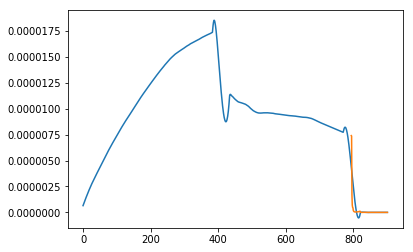

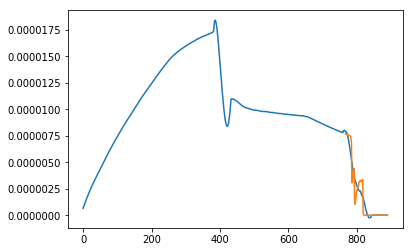

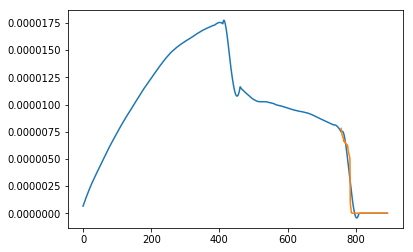

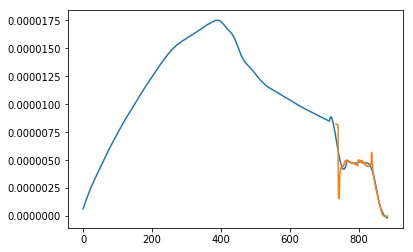

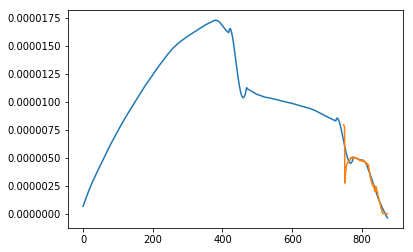

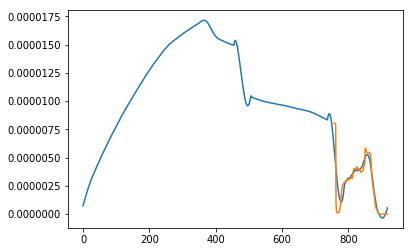

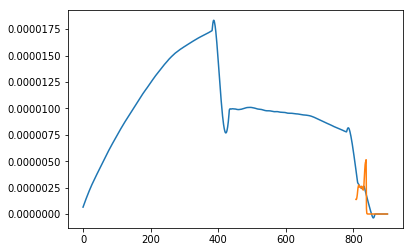

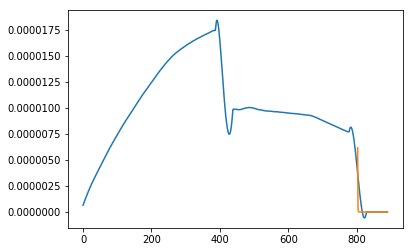

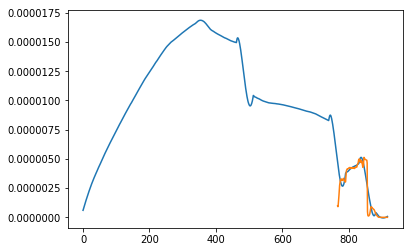

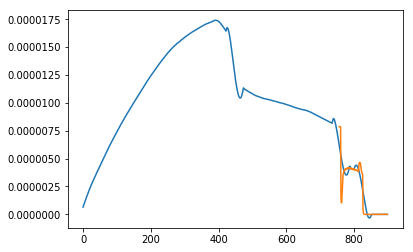

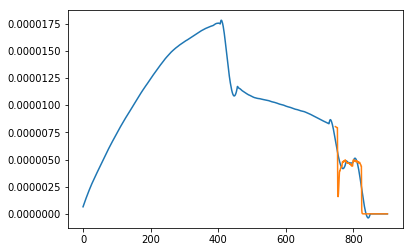

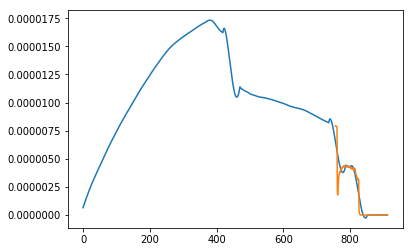

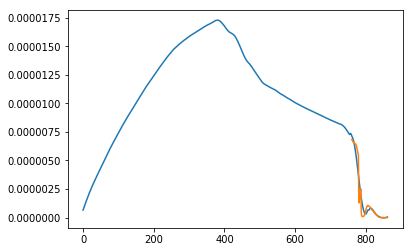

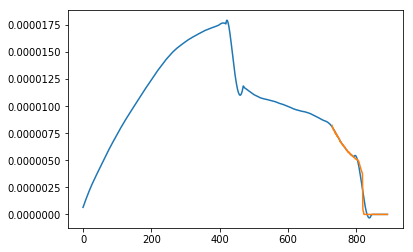

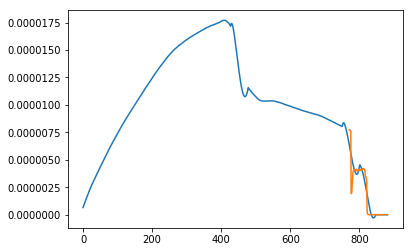

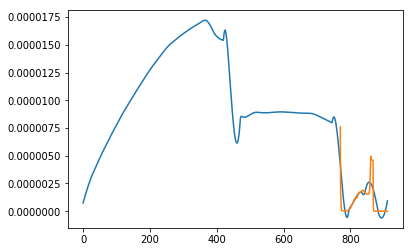

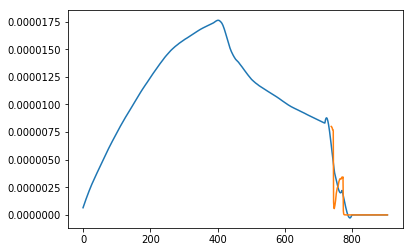

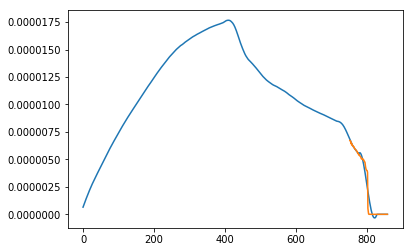

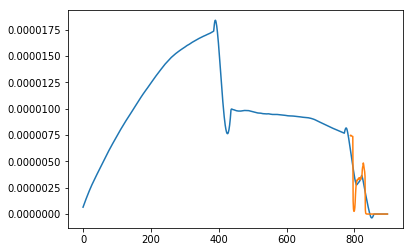

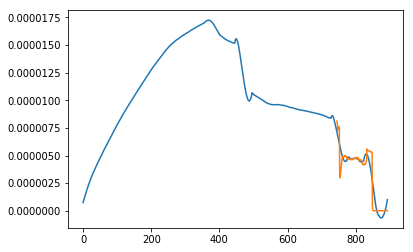

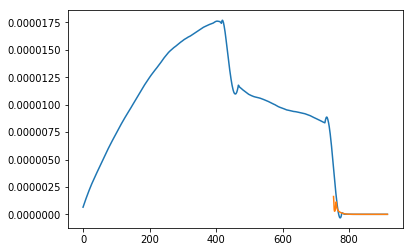

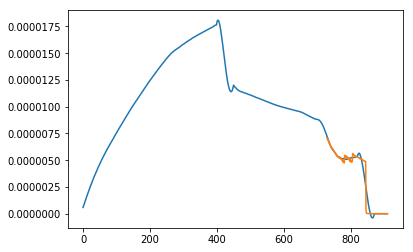

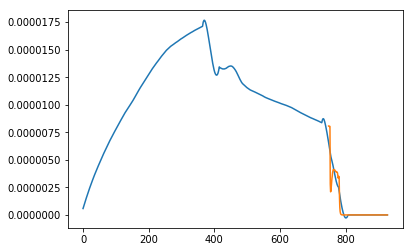

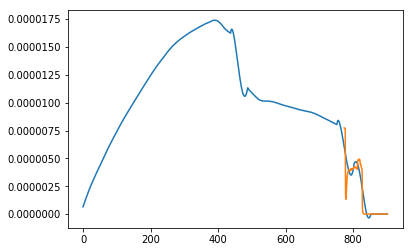

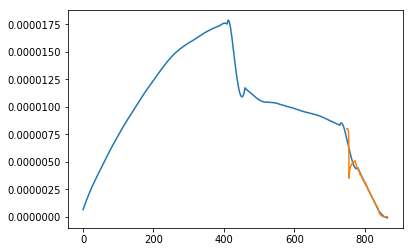

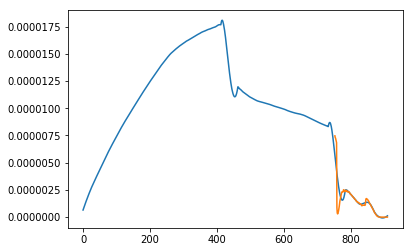

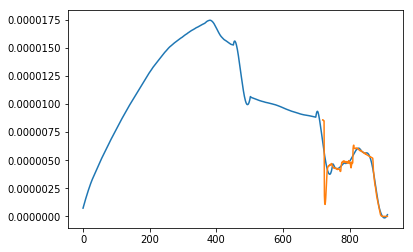

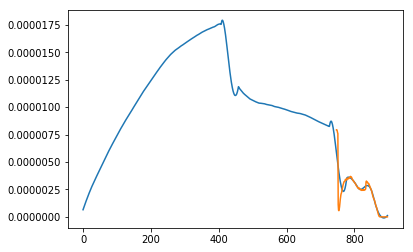

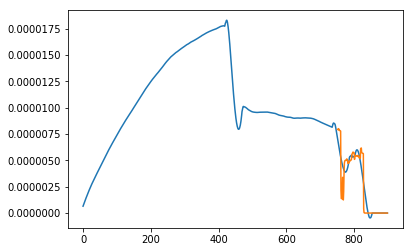

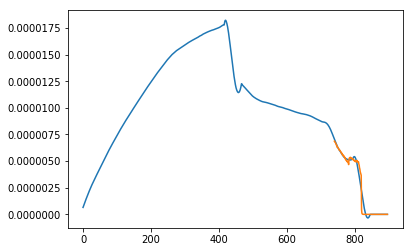

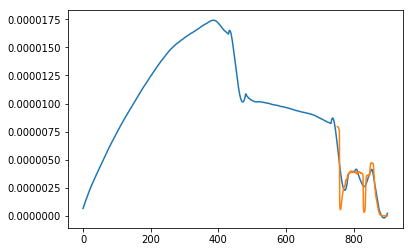

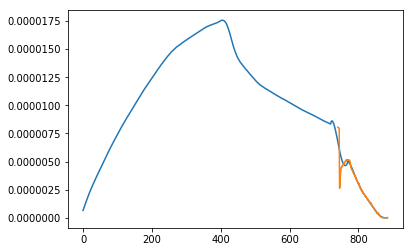

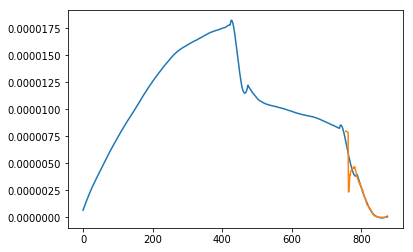

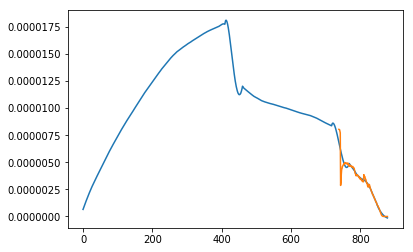

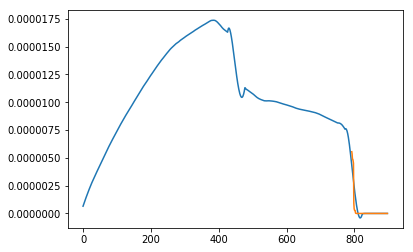

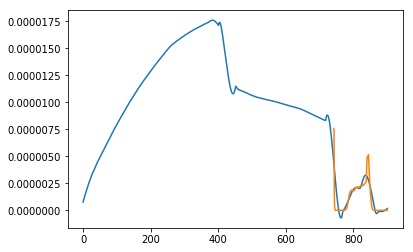

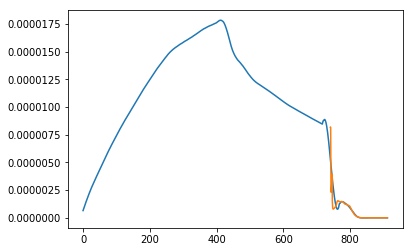

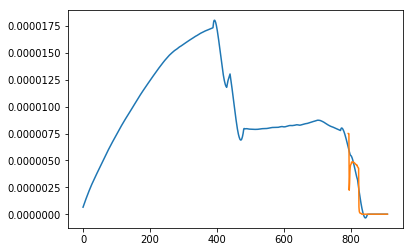

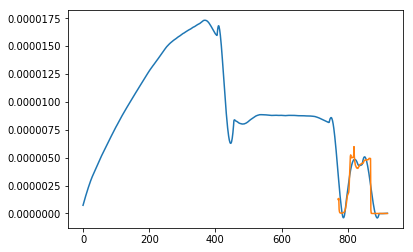

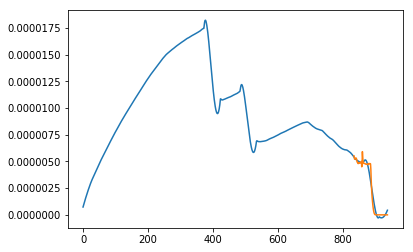

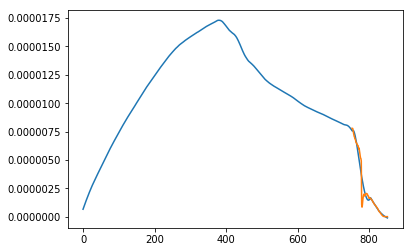

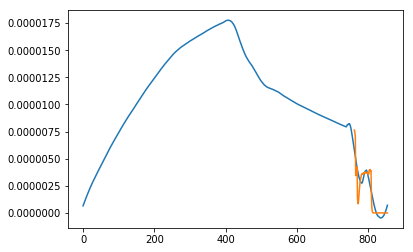

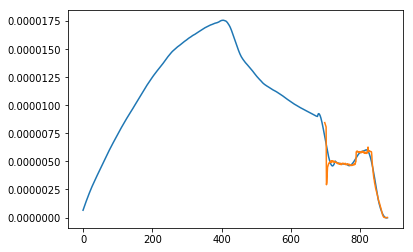

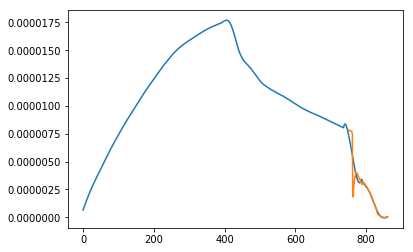

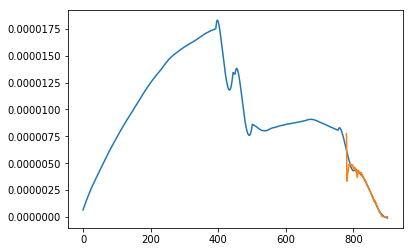

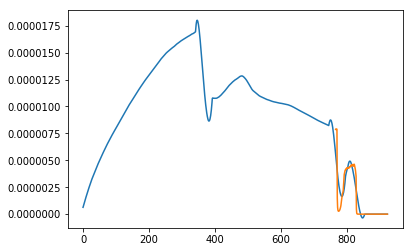

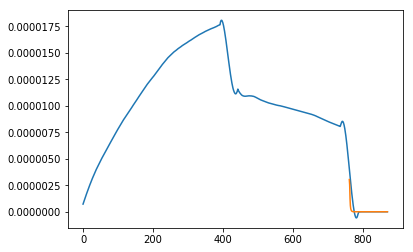

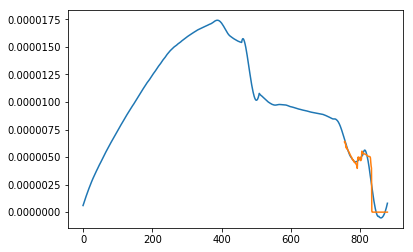

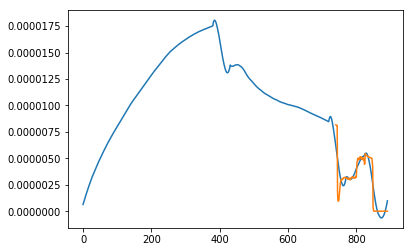

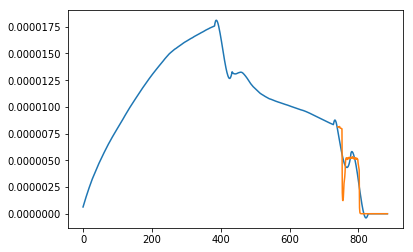

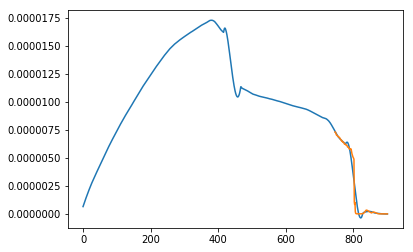

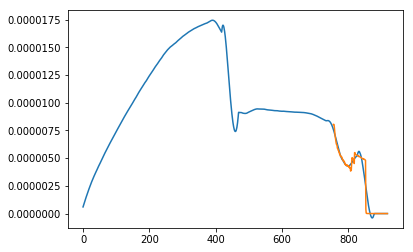

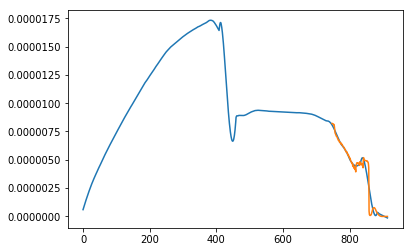

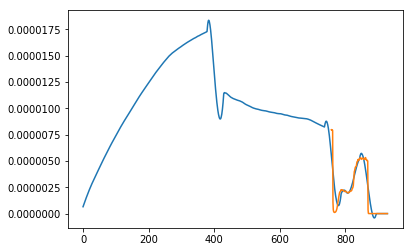

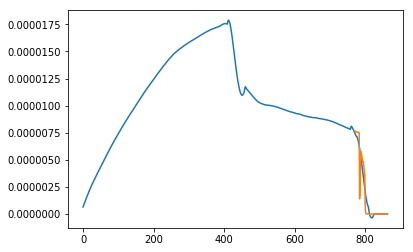

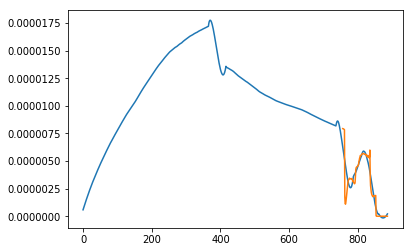

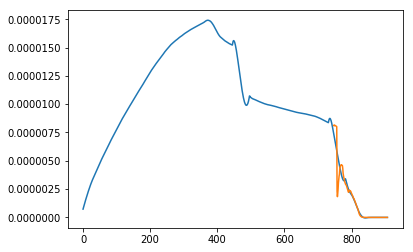

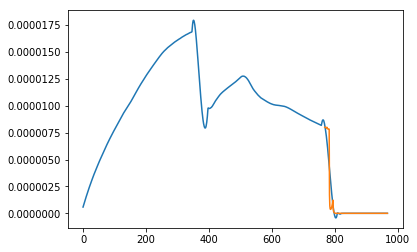

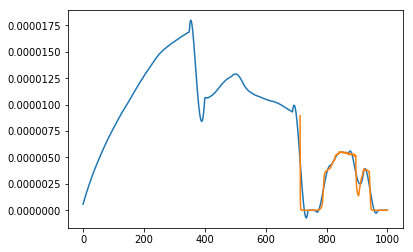

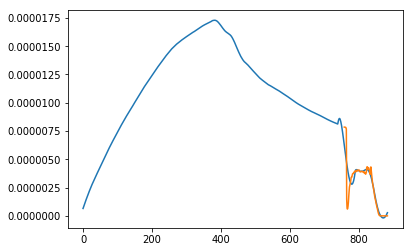

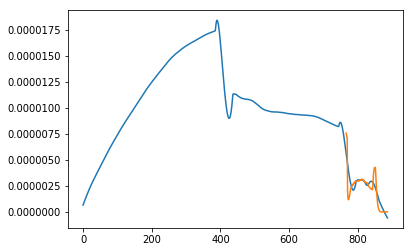

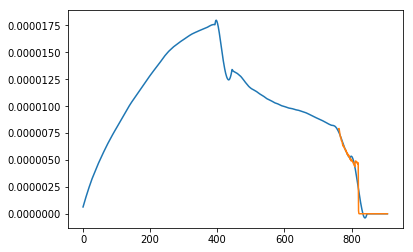

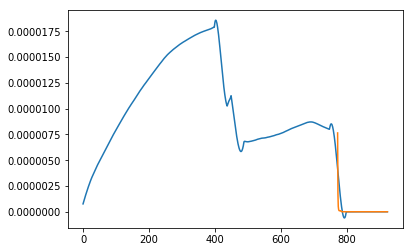

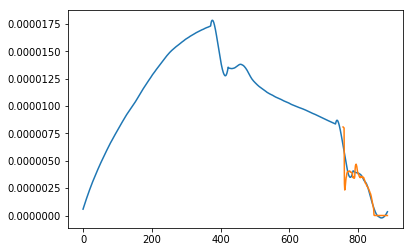

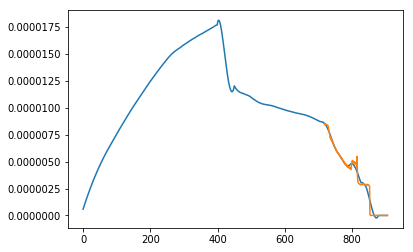

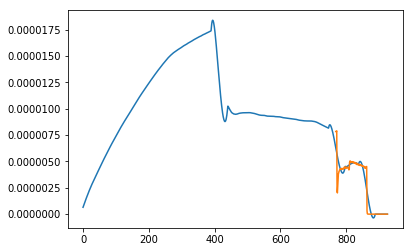

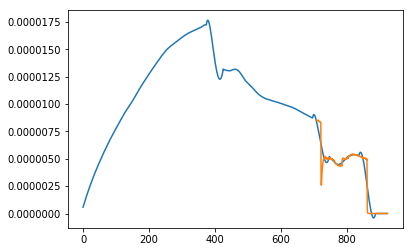

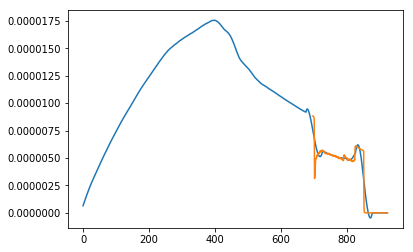

In [41]:
df_list, target_featurized = get_processed_df_list_and_target(raw_files, 1000, 1100)


In [36]:
len(df_list)

1000

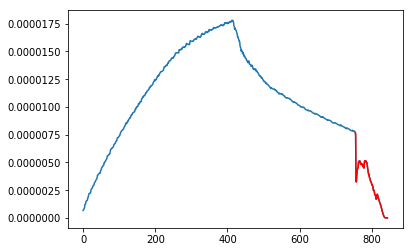

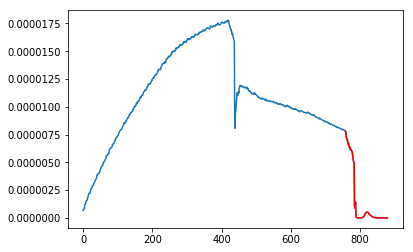

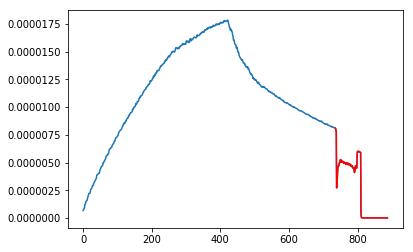

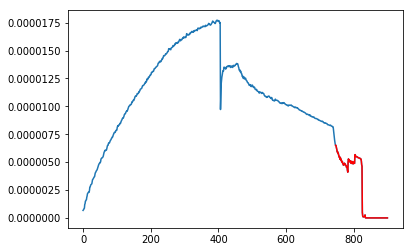

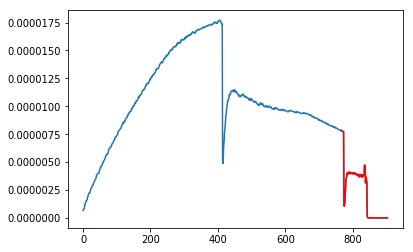

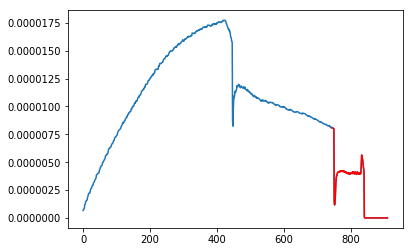

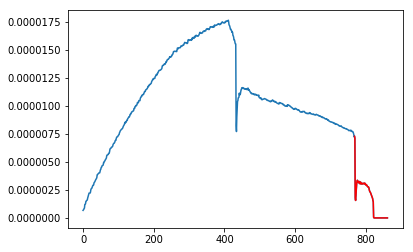

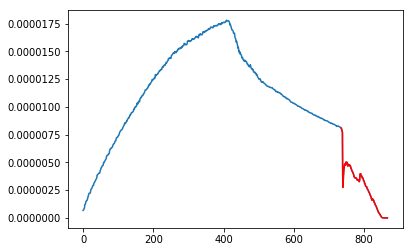

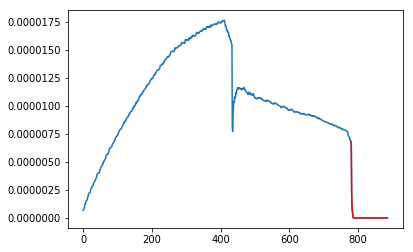

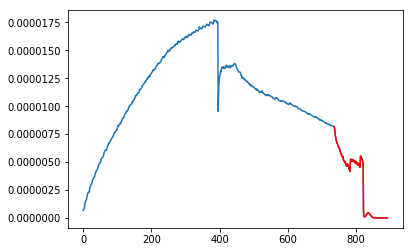

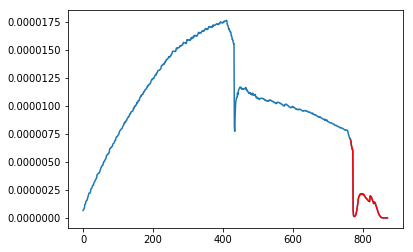

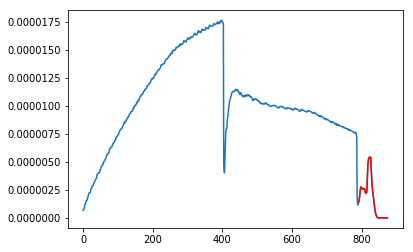

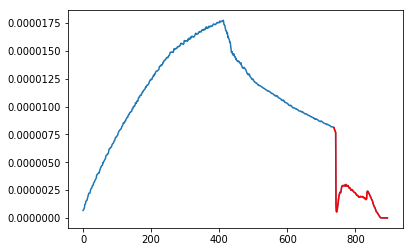

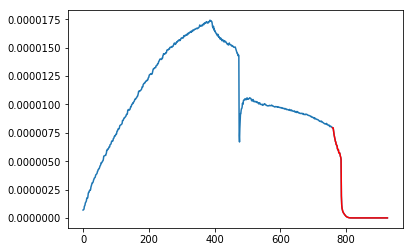

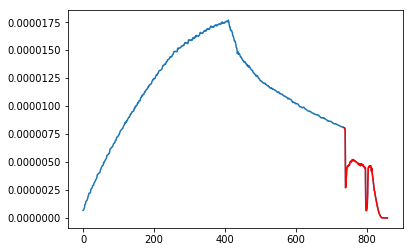

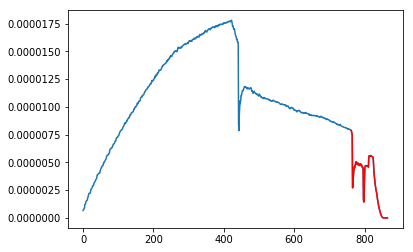

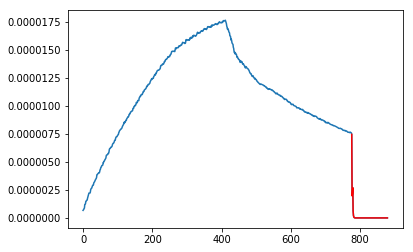

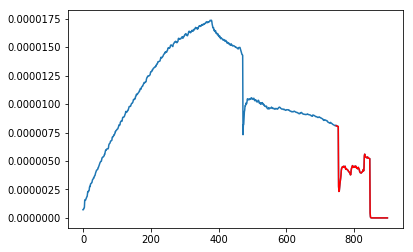

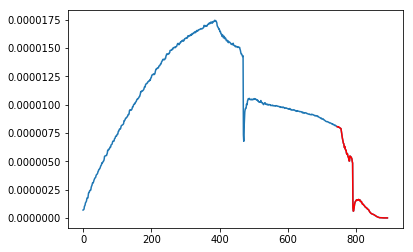

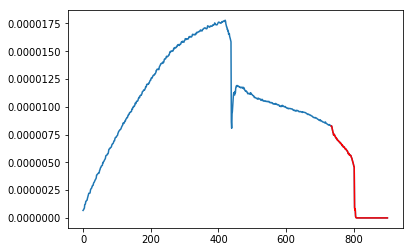

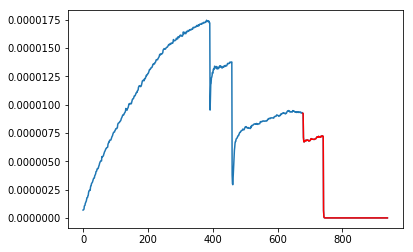

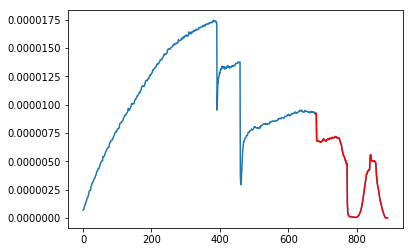

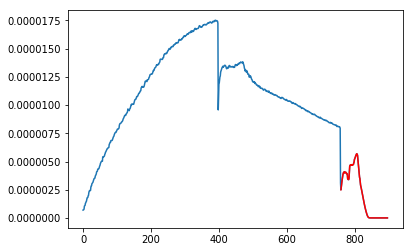

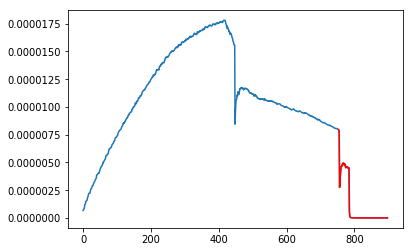

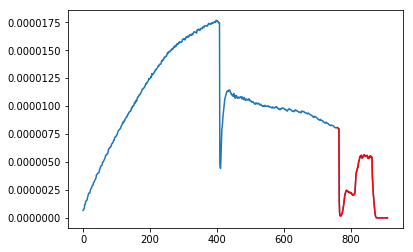

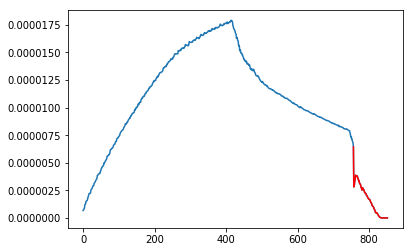

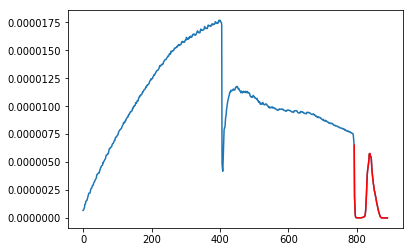

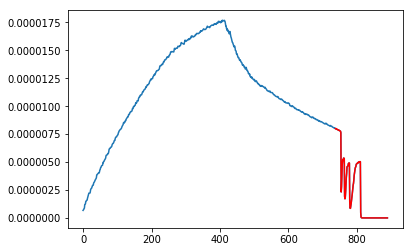

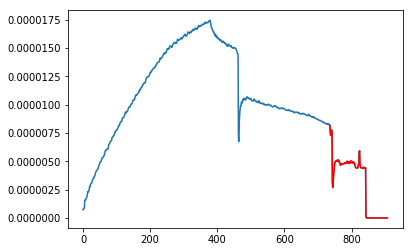

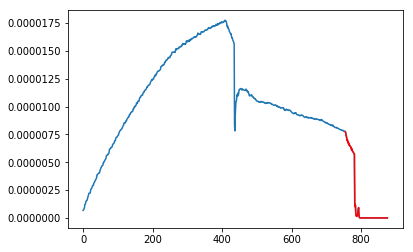

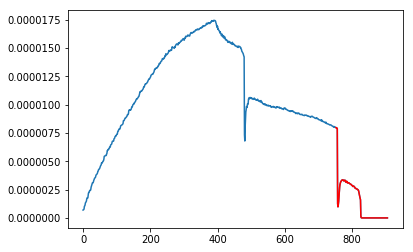

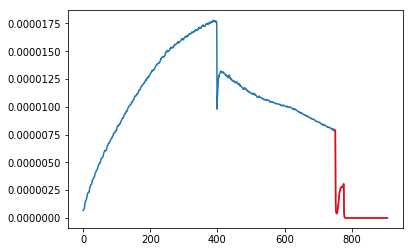

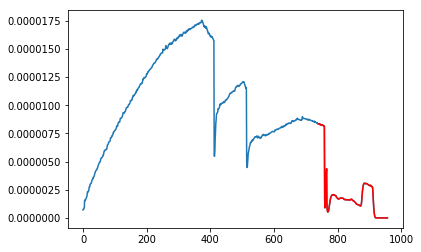

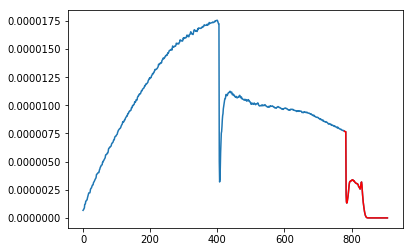

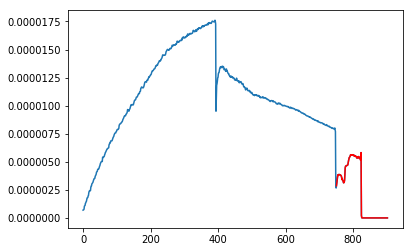

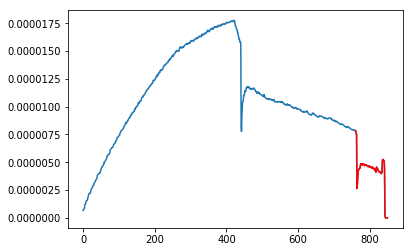

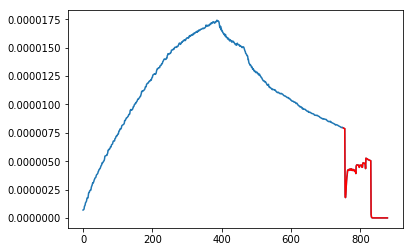

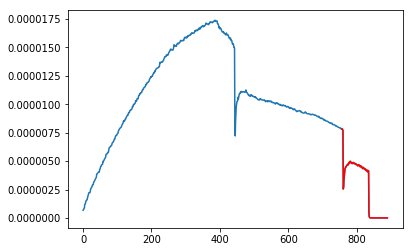

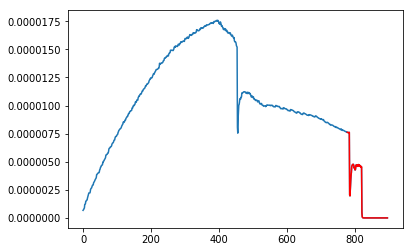

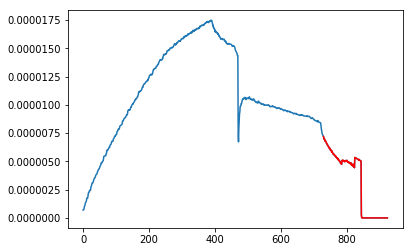

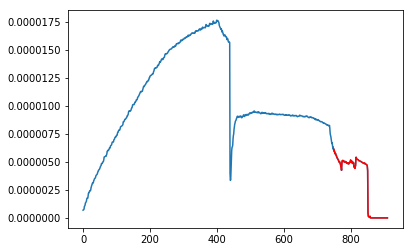

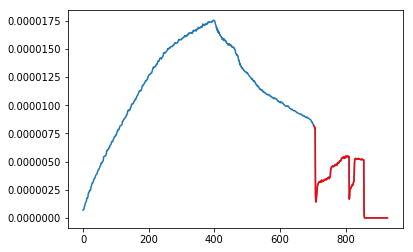

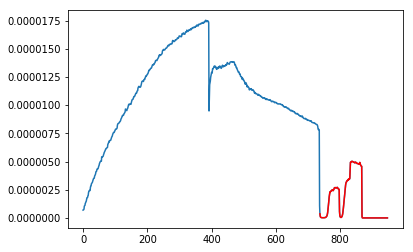

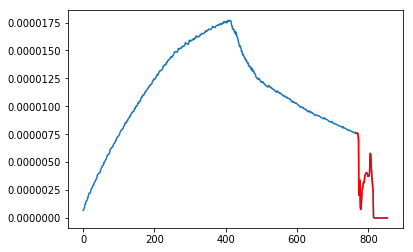

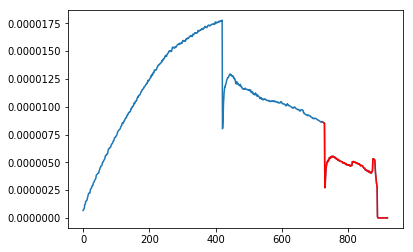

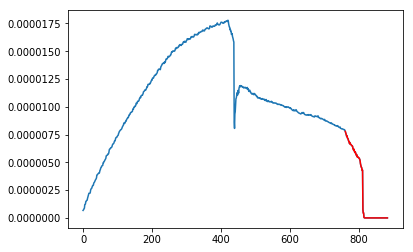

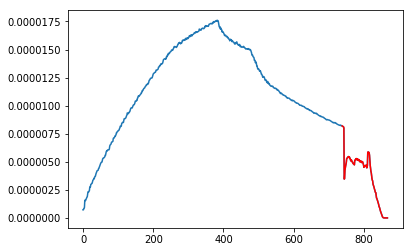

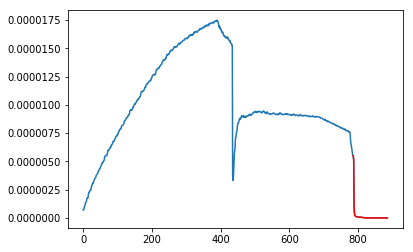

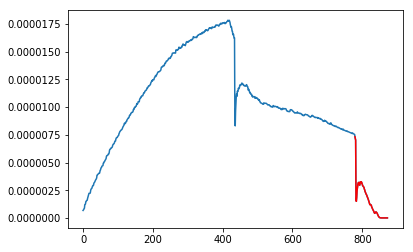

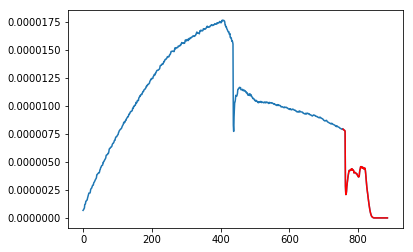

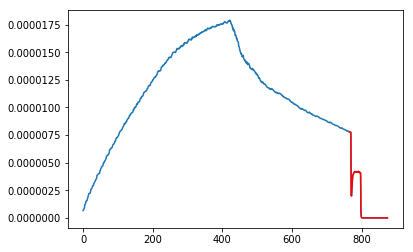

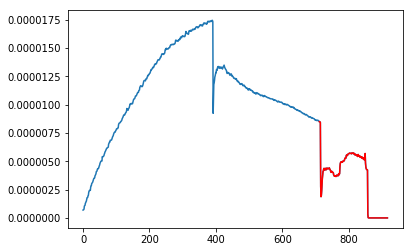

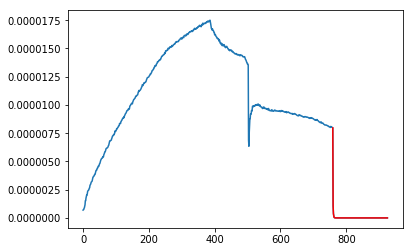

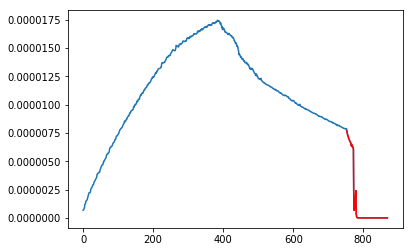

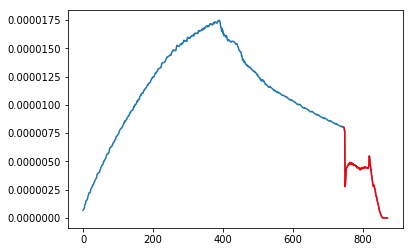

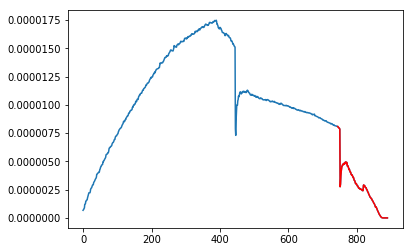

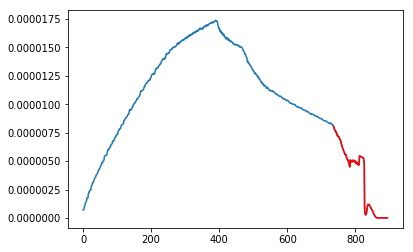

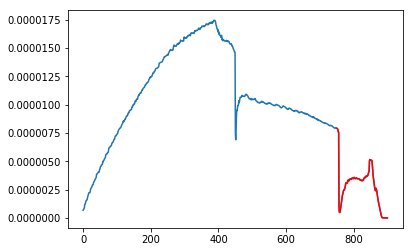

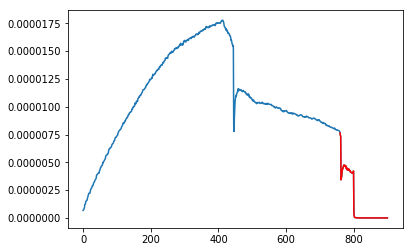

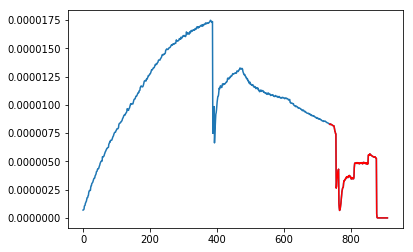

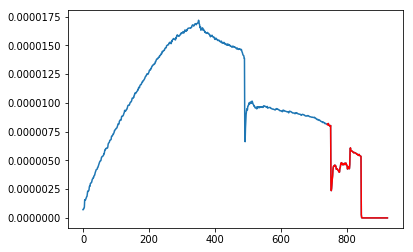

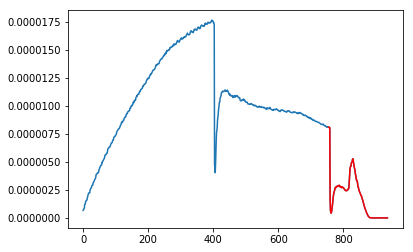

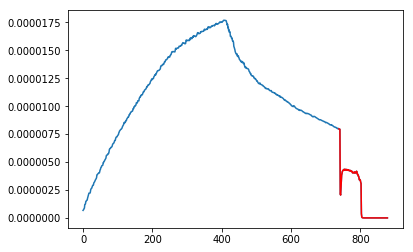

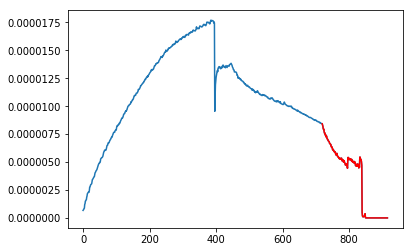

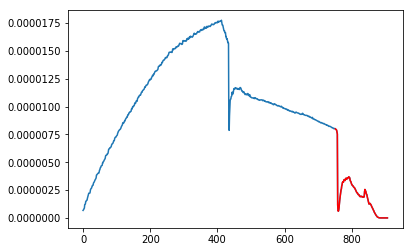

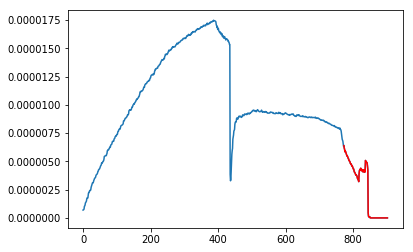

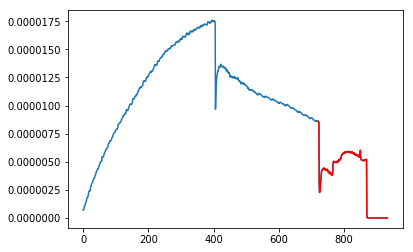

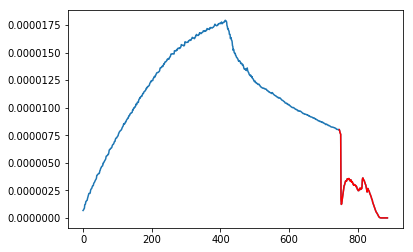

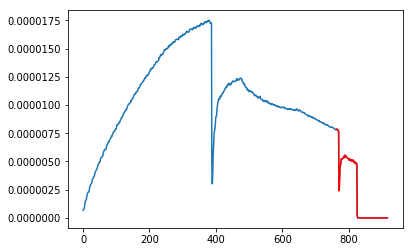

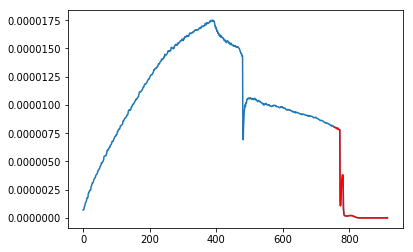

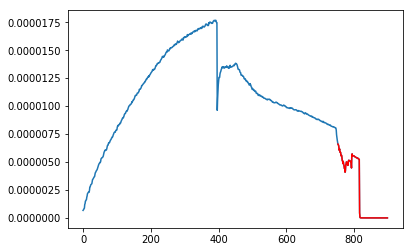

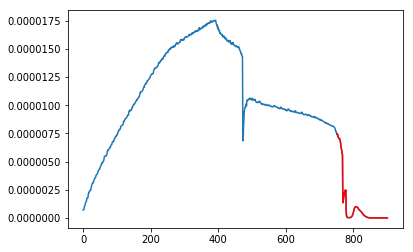

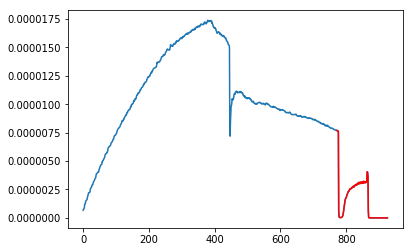

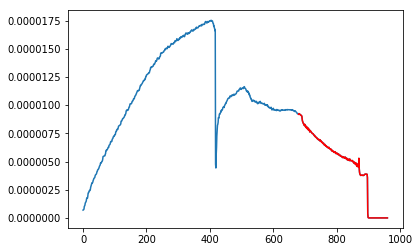

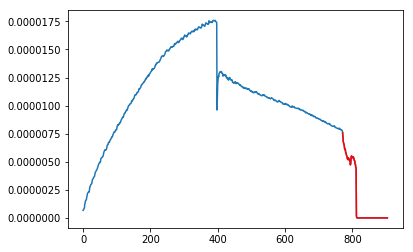

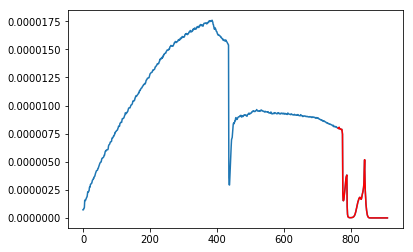

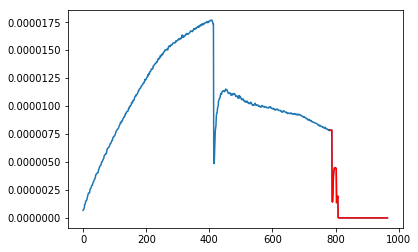

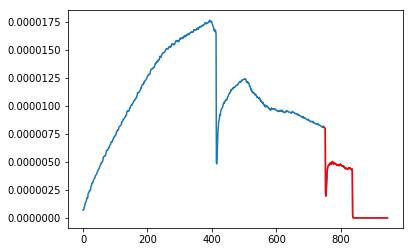

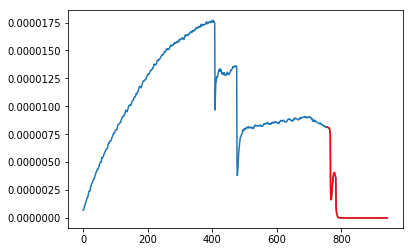

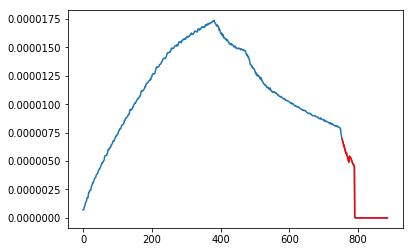

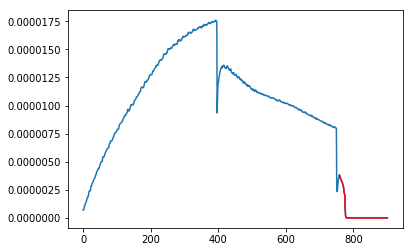

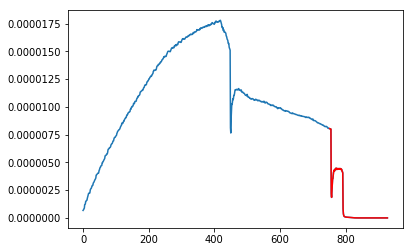

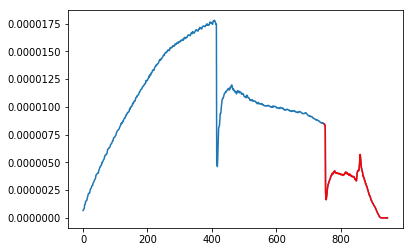

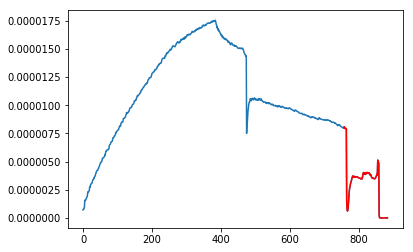

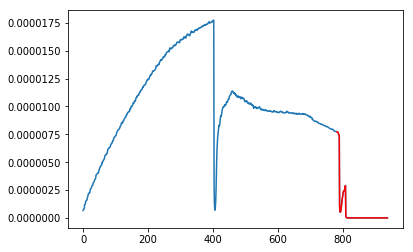

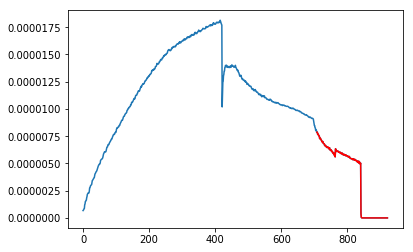

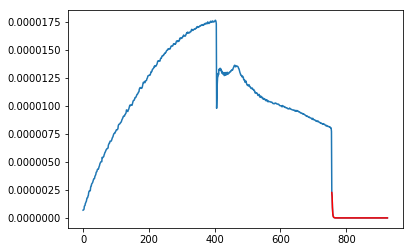

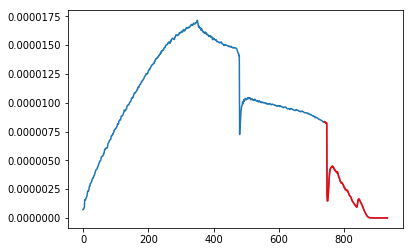

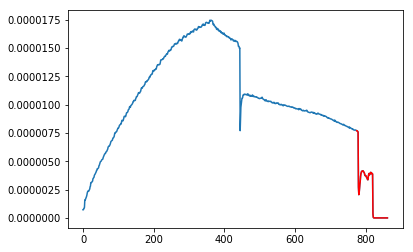

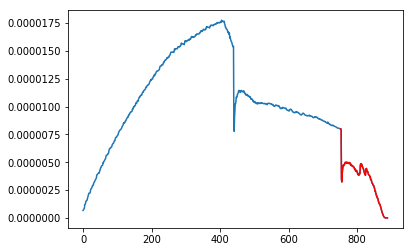

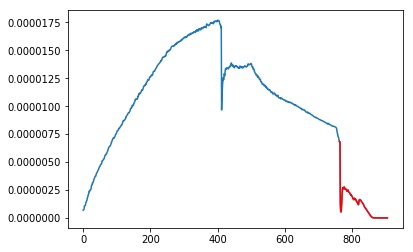

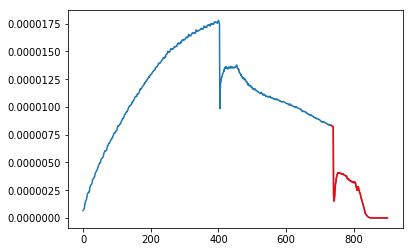

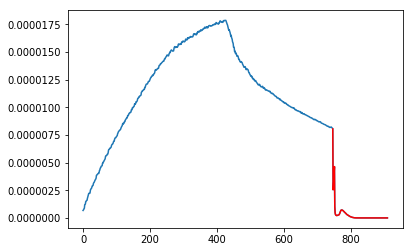

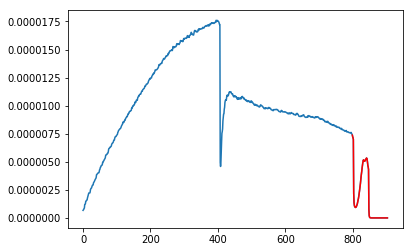

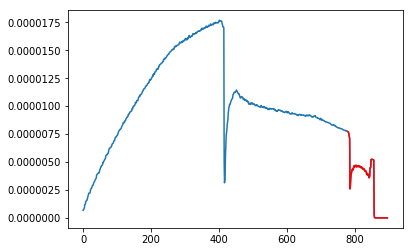

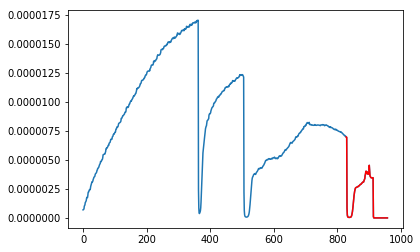

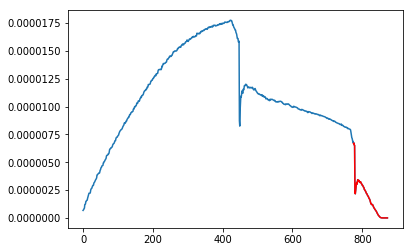

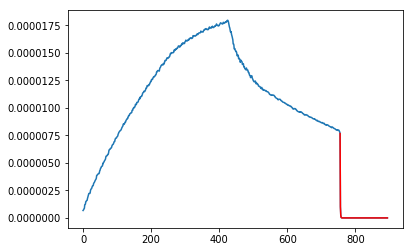

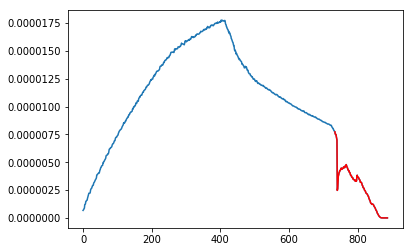

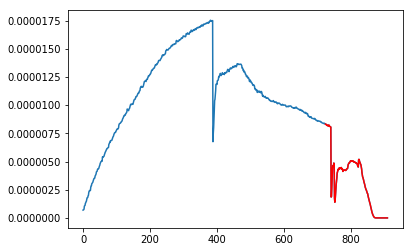

Tseries loaded


-------------------------------------------------- Modeling started --------------------------------------------------



100%|██████████| 29/29 [37:53<00:00, 78.41s/it] 

In [36]:

df_list, target_featurized = get_processed_df_list_and_target(raw_files, 0, 100)
print('Tseries loaded')


tseries = TimeSeriesFeaturizer(check_na=False)
model = tseries.featurize(df_list, n_jobs=-1)


In [37]:

import pickle

filehandler = open('tmp/tseries_folded_1.pickle', 'wb')
pickle.dump(tseries, filehandler)


In [29]:
import pickle
with open('tmp/tseries_folded_1.pickle', 'rb') as filehandler:
	tseries = pickle.load(filehandler)


In [44]:
for time in range(2,3):
    df_list, target_featurized = get_processed_df_list_and_target(raw_files, (time - 1) * 1_000, time * 1_000)
    print(f'Loaded DataFrame lists len is {len(df_list)}, from {(time - 1) * 1_000} to {time * 1_000}')
    featurized = tseries.featurize(df_list, n_jobs=4, apply_model=True)
    featurized.reset_index(drop=True).to_feather(f'tmp/last_fold/featurized_{time}')
    target_featurized.reset_index(drop=True).to_feather(f'tmp/last_fold/target_featurized_{time}')
    print('Stored the featurized files')


Loaded DataFrame lists len is 1000, from 1000 to 2000


-------------------------------------------------- Applying the model started --------------------------------------------------


100%|██████████| 29/29 [33:04<00:00, 16.42s/it]   


Stored the featurized files


In [46]:
featurized.shape

(1000, 3893)